In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial
import os 
 
import numpy as np
import panel as pn
pn.extension()
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import torch
torch.set_grad_enabled(False)
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchbend as tb
tb.set_output('notebook')
import rave 
 
from dandb import *

In [3]:
bs = 32
val_set = MNIST(root='datasets/MNIST', train=False, download=True, transform = transforms.ToTensor())
digit_loader = DataLoader(val_set, bs, shuffle=False)

In [4]:
vae = make_mnist_vae()
state_dict = torch.load('models/mnist_vae/final.ckpt')
vae.load_state_dict(state_dict)
vae.eval()
print('VAE instantiated and checkpoint loaded !')

/tmp/ipykernel_1364409/1163482513.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('models/mnist_vae/final.ckpt')


VAE instantiated and checkpoint loaded !


### First step :  how does a Variational Auto-Encoder (VAE) work

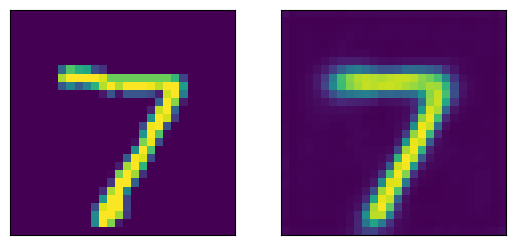

In [28]:
# Load a batch of digits from MNIST

x = next(iter(digit_loader))[0]

# Encode it into its latent representation
# Remember, it is equivalent to knobs of a synth (here, a digit synth)
mu, var = vae.encode(x)
latent_representation, _ = vae.reparametrize(mu, var)

# Use this latent representation to resynthesize input 
y = vae.decode(latent_representation)

# Display the result
BATCH_INDEX = 0
original_image = x[BATCH_INDEX].squeeze().numpy()
resynthesized_image = y[BATCH_INDEX].squeeze().numpy()
fig, ax = plt.subplots(1, 2)
ax[0].imshow(original_image)
ax[1].imshow(resynthesized_image)
_ = ax[0].set_xticks([])
_ = ax[0].set_yticks([])
_ = ax[1].set_xticks([])
_ = ax[1].set_yticks([])

Notice that the reconstruction is slightly blurry compared to the input. This a known issue with variational auto-encoders, however there exist techniques to mitigate this issue (cf. RAVE).

### Second step : bending and tracing our digit synth using torchbend

In [29]:
bended_vae = tb.BendedModule(vae)
bended_vae.trace(x=x)

In [30]:
activation_names = bended_vae.activation_names()
activation_shapes = list(map(bended_vae.activation_shape, activation_names))
print('forward method : ')
bended_vae.print_activations()

forward method : 


name,op,target,type,shape
x,placeholder,x,None,"(32, 1, 28, 28)"
encoder_net_conv0,call_module,encoder.net.conv0,None,"(32, 16, 14, 14)"
encoder_net_bn0,call_module,encoder.net.bn0,None,"(32, 16, 14, 14)"
encoder_net_act0,call_module,encoder.net.act0,None,"(32, 16, 14, 14)"
encoder_net_dr0,call_module,encoder.net.dr0,None,"(32, 16, 14, 14)"
encoder_net_conv1,call_module,encoder.net.conv1,None,"(32, 32, 7, 7)"
encoder_net_bn1,call_module,encoder.net.bn1,None,"(32, 32, 7, 7)"
encoder_net_act1,call_module,encoder.net.act1,None,"(32, 32, 7, 7)"
encoder_net_dr1,call_module,encoder.net.dr1,None,"(32, 32, 7, 7)"
encoder_net_conv2,call_module,encoder.net.conv2,None,"(32, 64, 4, 4)"


'-------------------  -------------  -------------------------------------------------------------    ----------------------------\nx                    placeholder    x                                                                torch.Size([32, 1, 28, 28])\nencoder_net_conv0    call_module    encoder.net.conv0                                                torch.Size([32, 16, 14, 14])\nencoder_net_bn0      call_module    encoder.net.bn0                                                  torch.Size([32, 16, 14, 14])\nencoder_net_act0     call_module    encoder.net.act0                                                 torch.Size([32, 16, 14, 14])\nencoder_net_dr0      call_module    encoder.net.dr0                                                  torch.Size([32, 16, 14, 14])\nencoder_net_conv1    call_module    encoder.net.conv1                                                torch.Size([32, 32, 7, 7])\nencoder_net_bn1      call_module    encoder.net.bn1                                  

### Dissecting the computational graph

In [31]:
act_names = [f'encoder_net_act{i}' for i in range(4)]+[f'decoder_net_act{i}' for i in range(2, 5)]
outs = bended_vae.get_activations(*act_names, x=x, fn='forward')

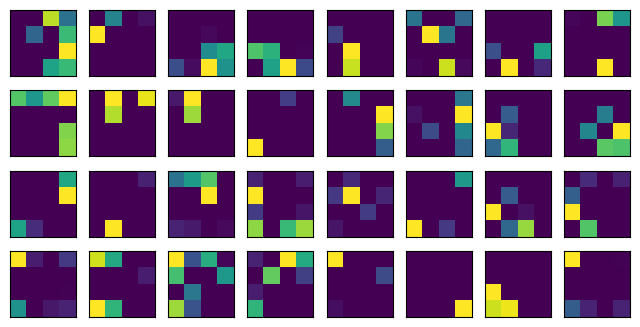

In [36]:
batch_idx = 4

plot_act = outs['decoder_net_act2'][batch_idx].detach().cpu().numpy()
fig, ax = plt.subplots(4, 8, figsize=(8, 4))
act_idx = 0
for i in range(4):
    for j in range(8):
        ax[i, j].imshow(plot_act[act_idx])
        _ = ax[i, j].set_xticks([])
        _ = ax[i, j].set_yticks([])
        act_idx+=1

### Dissecting the state dict

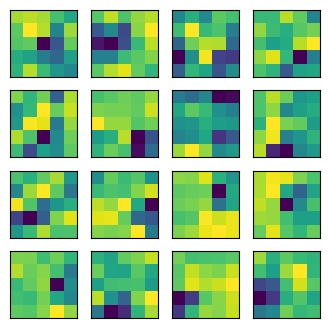

In [34]:
conv_weight = vae.decoder.net[-7].weight[16:32, 0].squeeze().cpu().data.detach().numpy()
fig, ax = plt.subplots(4, 4, figsize=(4, 4))
act_idx = 0
for i in range(4):
    for j in range(4):
        ax[i, j].imshow(conv_weight[act_idx])
        _ = ax[i, j].set_xticks([])
        _ = ax[i, j].set_yticks([])
        act_idx+=1